In [1]:
import matplotlib.pyplot as plt
from graspologic.simulations import sbm, er_np
from graspologic.plot import heatmap, pairplot
import numpy as np
%matplotlib inline
from graspologic.embed import MultipleASE as MASE
from graspologic.embed import AdjacencySpectralEmbed

import sys; sys.path.append('../')
from src.tools import iterate_align

%load_ext autoreload
%autoreload 2

In [2]:
def embed_mase(Xs, n_components=2):
    mase = MASE(n_components=n_components)
    V_hat = mase.fit_transform(Xs)
    Rs = mase.scores_
    return [V_hat @ R for R in Rs]

def embed_ase(Xs, n_components=2):
    return [AdjacencySpectralEmbed(n_components=n_components).fit_transform(X) for X in Xs]

In [2]:
G = er_np(100, 0.5)
V = AdjacencySpectralEmbed(n_components=2).fit_transform(G)
mean = np.mean(V, axis=0)
std = np.std(V, axis=0)
print(f'{mean[0]:.2f} +- {std[0]:.3f}')
print(f'{mean[1]:.2f} +- {std[1]:.3f}')

0.71 +- 0.066
-0.00 +- 0.304


In [352]:
n_subjs = 4
n_verts = 50
labels_sbm = n_verts * [0] + n_verts * [1]
P1 = np.array([[0.8, 0.2],
              [0.2, 0.4]])
P2 = np.array([[0.4, 0.2],
              [0.2, 0.8]])

# Generate SBMs from parameters
Ps = [P2, P2, P1, P1]
Xs = [sbm(2 * [n_verts], P) for P in Ps]
labels = labels_sbm*n_subjs
labels = np.hstack([[i]*n_verts*2 for i in range(n_subjs)])

# ps = [0.8, 0.8, 0.1, 0.1]
# labels = np.hstack([[i]*n_verts*2 for i in range(n_subjs)])
# # Generate ERs from parameters
# Xs = [er_np(2 * n_verts, p) for p in ps]

# ps = [0.5, 0.5, 0.5, 0.5]
# labels = np.hstack([[i]*n_verts*2 for i in range(n_subjs)])
# # Generate ERs from parameters
# Xs = [er_np(2 * n_verts, p) for p in ps]

In [354]:
Xs_mase = embed_mase(Xs, n_components=3)
Xs_ase = embed_ase(Xs, n_components=3)

for X in Xs_ase:
    print(np.linalg.norm(X, axis=0))

[6.66043499 4.10720444 2.84436993]
[6.68616555 4.01876966 2.8286541 ]
[6.62889607 4.12987377 2.85850838]
[6.67077785 4.14124732 2.83474215]


In [355]:
Xs_ase_aligned, _, _ = iterate_align(Xs_ase, None, None, max_iter=0)
Xs_ase_aligned_normed, _, _ = iterate_align(Xs_ase, None, None, norm=True, max_iter=5)
Xs_ase_aligned_iter, _, _ = iterate_align(Xs_ase, None, None, max_iter=5, thresh=0)
Xs_ase_aligned_noref, _, _ = iterate_align(Xs_ase, None, None, max_iter=5, thresh=0, reference_align=False)

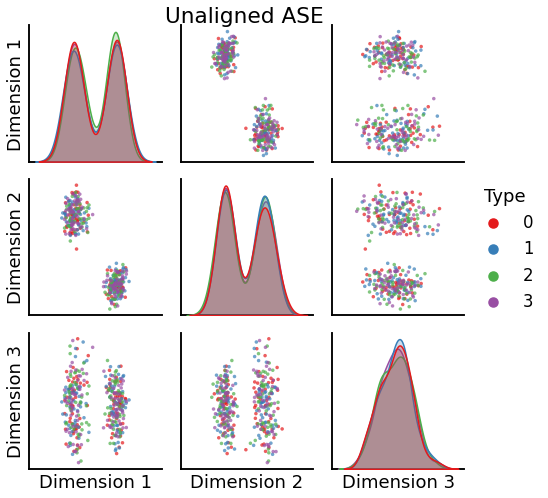

In [356]:
_ = pairplot(np.vstack(Xs_ase), labels=labels, title='Unaligned ASE')

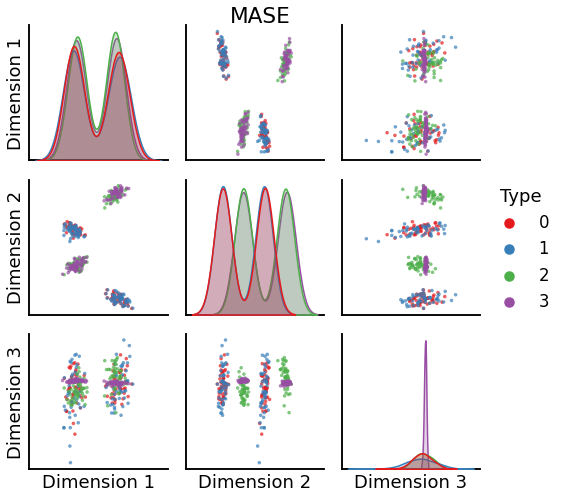

In [357]:
_ = pairplot(np.vstack(Xs_mase), labels=labels, title='MASE')

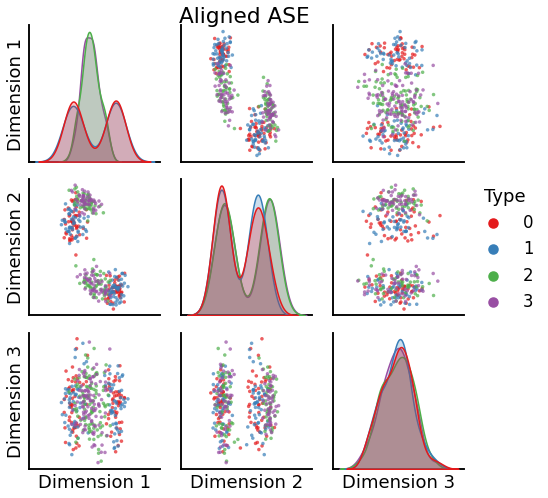

In [358]:
_ = pairplot(np.vstack(Xs_ase_aligned), labels=labels, title='Aligned ASE')

In [359]:
Xs_ase_aligned2, _, _ = iterate_align(np.asarray(Xs_ase)[np.asarray([2,3,0,1])], None, None, max_iter=0)
#labels = labels[np.asarray([2,3,0,1])]

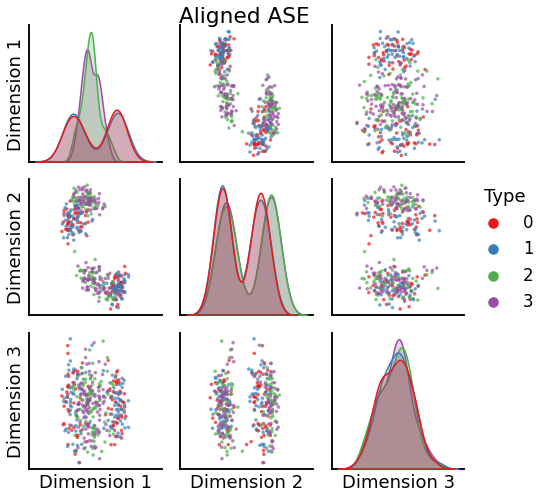

In [360]:
_ = pairplot(np.vstack(Xs_ase_aligned2), labels=labels, title='Aligned ASE')

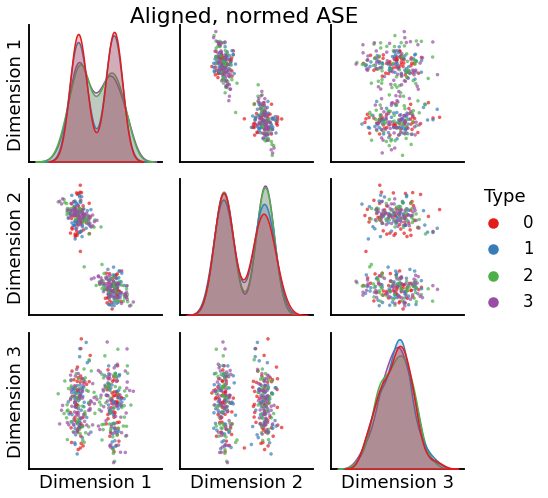

In [361]:
_ = pairplot(np.vstack(Xs_ase_aligned_normed), labels=labels, title='Aligned, normed ASE')

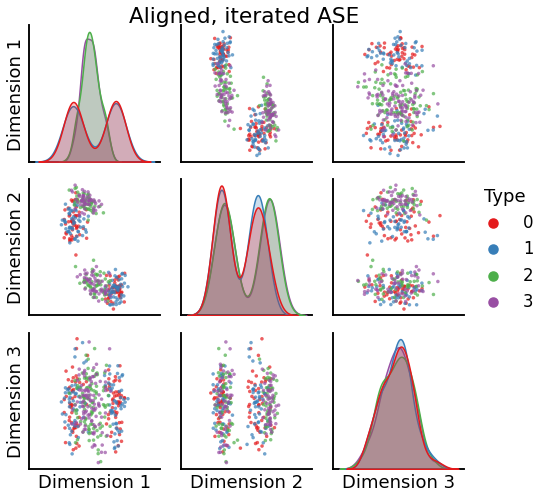

In [362]:
_ = pairplot(np.vstack(Xs_ase_aligned_iter), labels=labels, title='Aligned, iterated ASE')

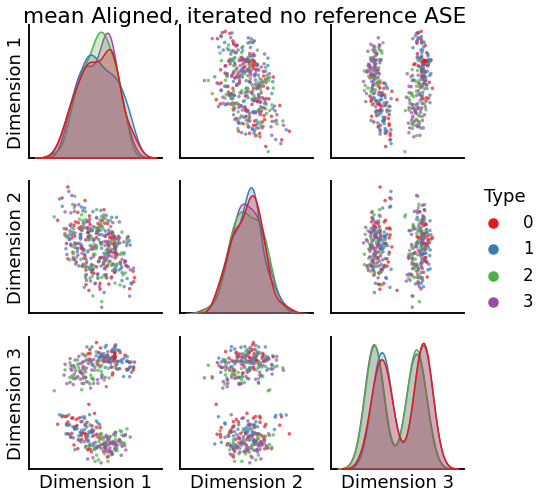

In [363]:
_ = pairplot(np.vstack(Xs_ase_aligned_noref), labels=labels, title='mean Aligned, iterated no reference ASE')

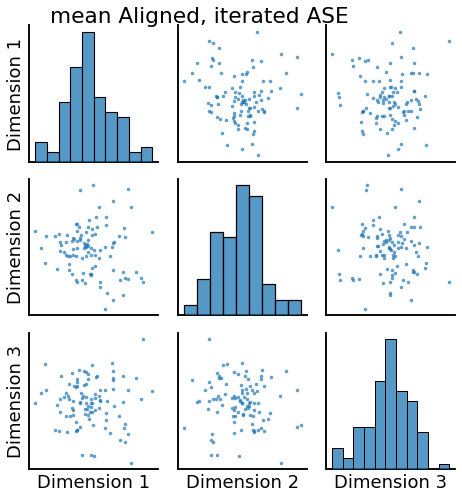

In [311]:
_ = pairplot(np.mean(Xs_ase_aligned_iter, axis=0), title='mean Aligned, iterated ASE')

## Multilevel

In [3]:
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize

def group_svd(Xs: np.ndarray) -> np.ndarray:
    # Create a concatenated view of Us
    Sall = np.linalg.norm(Xs, axis=1)
    Uall = Xs / np.linalg.norm(Xs, axis=1, keepdims=True)
    Uall_c = np.concatenate(Uall, axis=1)

    d = Sall.shape[1]
    UU, SS, VV = svds(Uall_c, d*5)
    sort_idx = np.argsort(SS)[::-1]
    SS = SS[sort_idx]
    UU = UU[:, sort_idx]
    group_U = UU[:,:d]
    VV = VV.T[:, sort_idx]
    VV = VV[:, :d]

    # SVDS the concatenated Us
    idx_end = 0
    projection_mats = []
    n = len(Xs)
    for i in range(n):
        idx_start = idx_end
        idx_end = idx_start + d
        VVi = normalize(VV[idx_start:idx_end, :], "l2", axis=0)

        # Compute the canonical projections
        A = np.linalg.solve(np.diag(Sall[i]), VVi)
        projection_mats.append(A)
        
    return np.asarray([X @ pmat for X, pmat in zip(Xs, projection_mats)])

    # return SS, np.asarray([group_U @ (group_U.T @ U) for U in Uall])

In [5]:
n_subjs = 4
n_repeats = 2
n_verts = 100
# labels_sbm = n_verts * [0] + n_verts * [1]
# P1 = np.array([[0.8, 0.2],
#               [0.2, 0.4]])
# P2 = np.array([[0.4, 0.2],
#               [0.2, 0.8]])

# # Generate SBMs from parameters
# Ps = [P2, P2, P1, P1]
# Xs = [sbm(2 * [n_verts], P) for P in Ps]
# labels = labels_sbm*n_subjs
# labels = np.hstack([[i]*n_verts*2 for i in range(n_subjs)])

ps = np.hstack([[np.random.uniform(0,1)]*n_repeats for _ in range(n_subjs)])
print(ps)
labels = np.hstack([np.hstack([[f'subj {i+1}, {r+1}']*n_verts for r in range(n_repeats)]) for i in range(n_subjs)])
subjs = np.hstack([[i]*n_repeats for i in range(n_subjs)])
# Generate ERs from parameters
Xs = [er_np(n_verts, p) for p in ps]

[0.65990432 0.65990432 0.54753799 0.54753799 0.14128677 0.14128677
 0.16897296 0.16897296]


In [6]:
Xs_mase = embed_mase(Xs, n_components=3)
Xs_ase = embed_ase(Xs, n_components=3)

for X in Xs_ase:
    print(np.linalg.norm(X, axis=0))
    
Xs_ase_aligned, _, _ = iterate_align(Xs_ase, None, None, max_iter=0)
Xs_ase_aligned_iter, _, _ = iterate_align(Xs_ase, None, None, max_iter=5, thresh=0)
Xs_ase_aligned_mean, _, _ = iterate_align(Xs_ase, labels, subjs, max_iter=0, thresh=0, mean_align=True)
Xs_ase_group = group_svd(Xs_ase)

[8.17612612 3.08503352 3.02848909]
[8.10446721 3.05656647 3.05399752]
[7.44588934 3.10663707 3.03581222]
[7.47972865 3.05278569 3.017973  ]
[3.93281151 2.60155075 2.56675575]
[3.89534903 2.60938891 2.56389858]
[4.23034911 2.69949221 2.64945686]
[4.28634815 2.68820729 2.65373079]


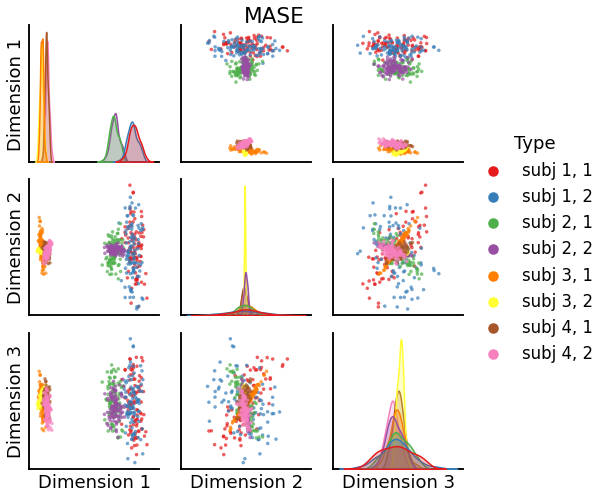

In [7]:
_ = pairplot(np.vstack(Xs_mase), labels=labels, title='MASE')

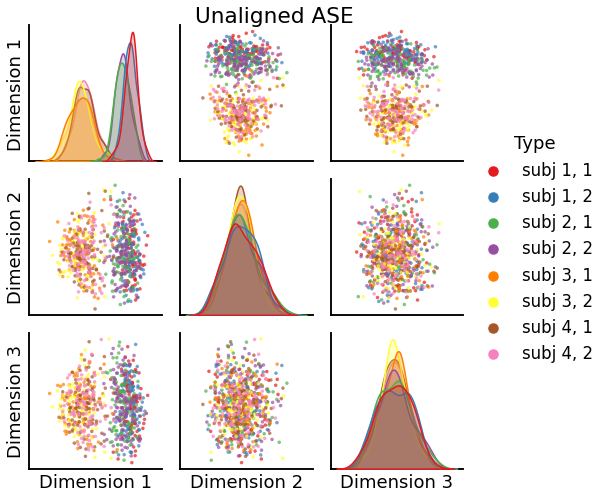

In [8]:
_ = pairplot(np.vstack(Xs_ase), labels=labels, title='Unaligned ASE')

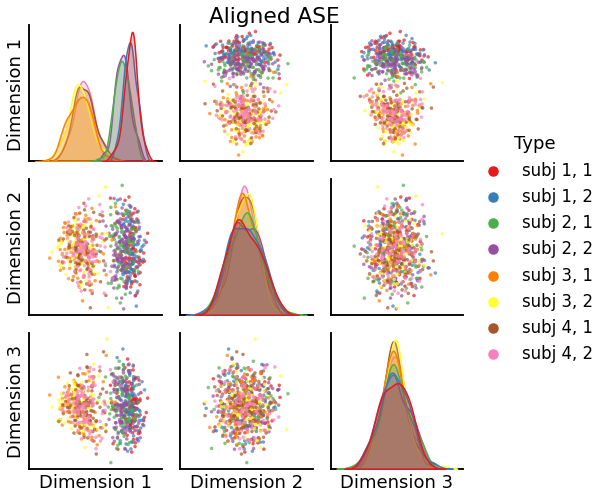

In [9]:
_ = pairplot(np.vstack(Xs_ase_aligned), labels=labels, title='Aligned ASE')

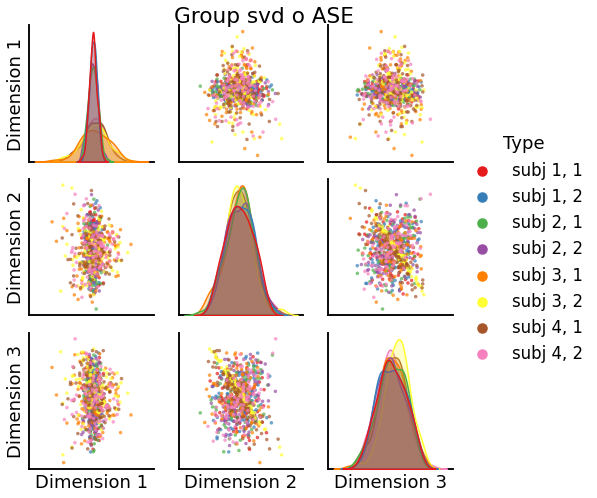

In [10]:
_ = pairplot(np.vstack(Xs_ase_group), labels=labels, title='Group svd o ASE')

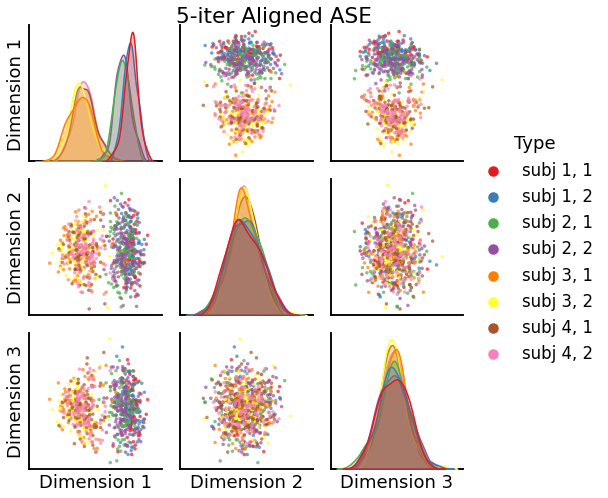

In [11]:
_ = pairplot(np.vstack(Xs_ase_aligned_iter), labels=labels, title='5-iter Aligned ASE')

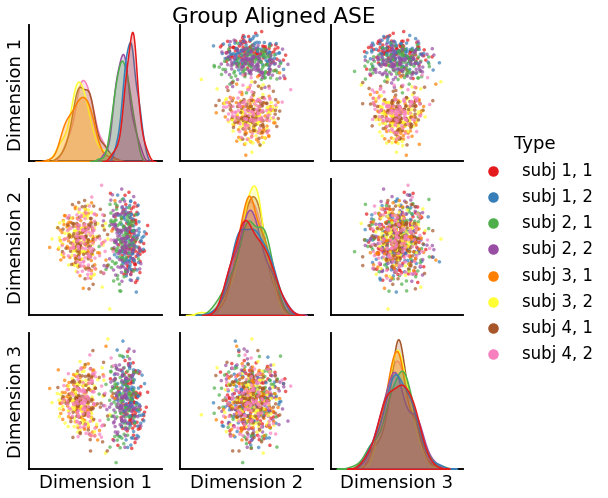

In [12]:
_ = pairplot(np.vstack(Xs_ase_aligned_mean), labels=labels, title='Group Aligned ASE')

In [13]:
def run_perc(data, thresh):
    perc_all = np.zeros(data.shape[0])
    for n,i in enumerate(data):
        data[n, i < np.percentile(i, thresh)] = 0.
    for n,i in enumerate(data):
        data[n, i < 0.] = 0.
    return data

def compute_affinity(K, step2=True):
    """
    Computes a subject affinity matrix, using diffusion map.
    """

    # Calculate Cov mat
    K = (K.T - np.nanmean(K, axis = 1)).T
    K = (K.T / np.nanstd(K, axis = 1)).T
    K[np.isnan(K)] = 0.0

    A_mA = K - K.mean(1)[:,None]
    ssA = (A_mA**2).sum(1)
    Asq = np.sqrt(np.dot(ssA[:,None],ssA[None]))
    Adot = A_mA.dot(A_mA.T)

    K = Adot/Asq
    del A_mA, ssA, Asq, Adot
    K = run_perc(K, 90)

    norm = (K * K).sum(0, keepdims=True) ** .5
    K = K.T @ K
    L_alpha = K / norm / norm.T
    
    if not step2:
        return L_alpha
    # Calculate diffusion map
    ndim = L_alpha.shape[0]
    alpha = 0.5

    if alpha > 0:
        # Step 2
        d = np.array(L_alpha.sum(axis=1)).flatten()
        d_alpha = np.power(d, -alpha)
        L_alpha = d_alpha[:, np.newaxis] * L_alpha 
        L_alpha = L_alpha * d_alpha[np.newaxis, :]

    # Step 3
    d_alpha = np.power(np.array(L_alpha.sum(axis=1)).flatten(), -1)

    L_alpha = d_alpha[:, np.newaxis] * L_alpha

    return L_alpha

In [36]:
from mapalign import embed
from scipy.sparse.linalg import eigsh, eigs, svds

x = np.random.normal(0,1,(100,10))
a = compute_affinity(x, step2=False)

emb, res = embed.compute_diffusion_map(
    a, alpha = 0.5, n_components=5, skip_checks=True, overwrite=True, eigen_solver=eigs, return_result=True)

In [44]:
x = np.random.normal(0,1,(100,10))
a = compute_affinity(x, step2=True)

In [37]:
u,s,v = svds(a, 5)

In [40]:
u.mean(0)

array([ 0.00362986, -0.00263227, -0.0046152 , -0.00150284, -0.09875753])